In [1]:
%pip install scikit-learn
%pip install keybert

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from keybert import KeyBERT
import matplotlib.pyplot as plt
from collections import Counter

C:\Users\selam\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
rating_df=pd.read_csv("../data/rating.csv")
domain_locations_df = pd.read_csv("../data/domains_location.csv")
traffic_data_df = pd.read_csv("../data/traffic.csv")

# Drop duplicates
rating_df.drop_duplicates(inplace=True)
domain_locations_df.drop_duplicates(inplace=True)
traffic_data_df.drop_duplicates(inplace=True)

# Drop unnecessary columns
if 'source_id' in rating_df.columns:
    rating_df.drop(columns=['source_id'], inplace=True)

if 'url_to_image' in rating_df.columns:
    rating_df.drop(columns=['url_to_image'], inplace=True)

# Drop rows with missing values
rating_df = rating_df.dropna(axis=0)
domain_locations_df = domain_locations_df.dropna(axis=0)

# rating_df['domain'] = rating_df['url'].apply(get_domain)

merge_df=pd.merge(rating_df, domain_locations_df ,left_on='source_name', right_on ='SourceCommonName' ,how ='left')
merge_df=pd.merge(merge_df, traffic_data_df , left_on ='source_name' ,right_on='Domain' ,how ='left')

In [4]:
model = KeyBERT()

# Function to extract keywords
def extract_keywords(text):
    keywords = model.extract_keywords(text)
    return [kw[0] for kw in keywords]

# Apply keyword extraction to title and content columns
merge_df['title_keywords'] = merge_df['title'].apply(extract_keywords)
merge_df['content_keywords'] = merge_df['content'].apply(extract_keywords)

# Compute Jaccard similarity between title and content keywords
def compute_similarity(row):
    title_keywords = set(row['title_keywords'])
    content_keywords = set(row['content_keywords'])
    intersection = title_keywords.intersection(content_keywords)
    union = title_keywords.union(content_keywords)
    similarity = len(intersection) / len(union) if len(union) > 0 else 0
    return similarity

merge_df['keyword_similarity'] = merge_df.apply(compute_similarity, axis=1)

# Print DataFrame with keyword similarity
print(merge_df[['title', 'content', 'keyword_similarity']])


                                                   title  \
0      superstar chef yannick alléno brings refined f...   
1      amphibians are the world’s most vulnerable spe...   
2                  image: rusty red waters in madagascar   
3      everything leaving max (formerly hbo max) in n...   
4      unga calls for humanitarian truce in israel-ha...   
...                                                  ...   
52388  Have done no wrong, only did party work, says ...   
52389  FC Barcelona Guarantees $77.6 Million Champion...   
52390  Three hospitals ignored her gravely ill fiancé...   
52391  Kerber’s Farm: Bringing Farm To Table To Manha...   
52392  Tips For Investing In Short-Term Rentals In Dubai   

                                                 content  keyword_similarity  
0      Pavyllon London, at Four Seasons Hotel London ...            0.250000  
1      The worlds frogs, salamanders, newts and other...            0.111111  
2      Iron-rich sediment colors the red-o

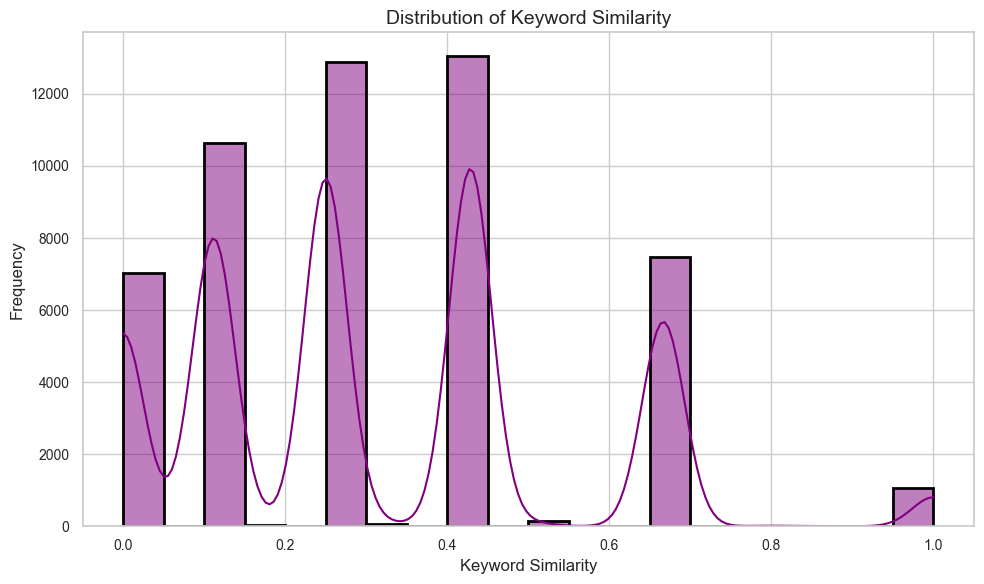

In [5]:
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot histogram of keyword similarity with KDE plot
plt.figure(figsize=(10, 6))
sns.histplot(merge_df['keyword_similarity'], bins=20, kde=True, color='purple', linewidth=2,
             edgecolor='black')  # Change the color to light green and add black edge color
plt.xlabel('Keyword Similarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Keyword Similarity', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
